In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from sklearn import decomposition
import fbpca
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt

In [3]:
pd.options.display.max_colwidth = 500

In [4]:
d = pd.read_csv('readwise-data.csv')
d.head()

,Highlight,Book Title,Book Author,Amazon Book ID,Note,Color,Tags,Location Type,Location,Highlighted at
0,"Saint-Just made it clear that the reach of virtuous terror would be very wide: ""There is no prosperity to hope for as long as the last enemy of liberty breathes. You have to punish not only the traitors, but even those who are indifferent; you have to punish whoever is passive in the republic, and who does nothing for it."" And, chillingly: ""What constitutes a republic is the total destruction of everything that stands opposed to it.""",The Guillotine Mystique,reason.com,NaN,NaN,NaN,NaN,order,2.0,2020-11-26 03:28:15+00:00
1,"Robespierre's grand vision was laid out in a February 1794 speech to the Convention titled ""The Principles of Political Morality."" The goal of the Republic, he declared, was to fulfill the true human potential that tyranny had warped: Selfishness, frivolity, greed, sensuality, vanity, and social graces would give way to magnanimity, wisdom, reason, and love of goodness, truth, and glory, ushering in ""the dawn of the bright day of universal happiness."" Until then, ""the despotism of liberty ag...",The Guillotine Mystique,reason.com,NaN,NaN,NaN,NaN,order,1.0,2020-11-26 03:28:09+00:00
2,"Besides privacy, another thing people are said to luxuriate in is hot water – a bath, a shower, a hot springs. Part of this is the pleasure of not having to expend energy maintaining temperature homeostasis. The pleasure of privacy is similar: freedom from having to expend cognitive energy in modeling others and conforming one’s behavior to the standards of public self-presentation, in order to maintain status homeostasis. Privacy is a form of rest.",Luxuriating in Privacy,ribbonfarm.com,NaN,NaN,NaN,favorite,order,1.0,2020-11-12 01:36:29+00:00
3,"When you’re trying to draw reliable inferences from improbable events, wiggle room is the enemy.",How Not to Be Wrong: The Power of Mathematical Thinking,Jordan Ellenberg,B00G3L6JQ4,NaN,NaN,NaN,order,19.0,2020-09-21 04:53:16.752500+00:00
4,"Most mathematicians would say that, in the end, the disasters and atrocities of history form what we call a partially ordered set. That’s a fancy way of saying that some pairs of disasters can be meaningfully compared and others cannot.",How Not to Be Wrong: The Power of Mathematical Thinking,Jordan Ellenberg,B00G3L6JQ4,NaN,NaN,discard,order,18.0,2020-09-21 04:53:16.752456+00:00


In [5]:
# Remove chapter headings
dd = d[~d['Note'].fillna('').str.contains(r'\.h\d')]

In [6]:
dd['Book Title'].value_counts().head(20)

Skin in the Game: Hidden Asymmetries in Daily Life                                                                                148
Sapiens: A Brief History of Humankind                                                                                             135
12 Rules for Life: An Antidote to Chaos                                                                                           134
Who We Are and How We Got Here: Ancient DNA and the New Science of the Human Past                                                 102
How to Have a Good Day: Harness the Power of Behavioral Science to Transform Your Working Life                                     76
Lenin: The Man, the Dictator, and the Master of Terror                                                                             70
The Road to Wigan Pier                                                                                                             65
The Autobiography of Malcolm X                                

## SVD

In [7]:
# Note: this removes chapter headings
cv = TfidfVectorizer(stop_words='english')
vectors = cv.fit_transform(dd['Highlight'].values)
vectors.shape

(2876, 19044)

In [8]:
vocab = cv.get_feature_names()

U:  (2876, 10)
Vh:  (10, 19044)


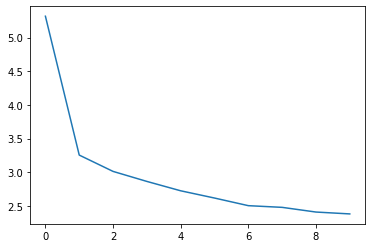

In [9]:
num_topics = 10
U, s, Vh = decomposition.randomized_svd(vectors, num_topics)
print('U: ', U.shape)
print('Vh: ', Vh.shape)
U = pd.DataFrame(U, columns=[f'Topic {idx}' for idx in range(num_topics)])
U['Top Topic'] = U.idxmax(axis=1)
Vh = pd.DataFrame(Vh.T, index=vocab, columns=[f'Topic {idx}' for idx in range(num_topics)])
j = pd.concat([dd, U], axis=1)
plt.plot(s)

In [10]:
j.columns

Index(['Highlight', 'Book Title', 'Book Author', 'Amazon Book ID', 'Note',
       'Color', 'Tags', 'Location Type', 'Location', 'Highlighted at',
       'Topic 0', 'Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5',
       'Topic 6', 'Topic 7', 'Topic 8', 'Topic 9', 'Top Topic'],
      dtype='object')

In [11]:
j['Top Topic'].value_counts()

Topic 0    1019
Topic 3     336
Topic 8     264
Topic 7     224
Topic 6     218
Topic 5     216
Topic 9     185
Topic 4     169
Topic 1     152
Topic 2      93
Name: Top Topic, dtype: int64

In [12]:
pt = pd.pivot_table(j, index='Book Title', columns='Top Topic', values='Highlight', aggfunc='count', fill_value=0)
pt = pt[pt.sum(axis=1) >= 10]
pt = pt / pt.sum(axis=1).values.reshape(-1,1)
pt.style.background_gradient(cmap ='viridis', axis=1) \
        .set_properties(**{'font-size': '12px'}) 

Top Topic,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
Book Title,,,,,,,,,,
12 Rules for Life: An Antidote to Chaos,0.333333,0.125000,0.041667,0.041667,0.000000,0.083333,0.000000,0.041667,0.083333,0.250000
A Random Walk Down Wall Street: The Time-Tested Strategy for Successful Investing (Eleventh Edition),0.555556,0.027778,0.000000,0.027778,0.000000,0.027778,0.000000,0.027778,0.194444,0.138889
Against the Grain: A Deep History of the Earliest States,0.269231,0.000000,0.000000,0.153846,0.000000,0.076923,0.000000,0.038462,0.423077,0.038462
Are We Smart Enough to Know How Smart Animals Are?,0.156250,0.000000,0.000000,0.000000,0.281250,0.031250,0.500000,0.031250,0.000000,0.000000
Darwin's Dangerous Idea: Evolution and the Meaning of Life,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.300000,0.100000,0.000000,0.200000
"Debt - Updated and Expanded: The First 5,000 Years",0.111111,0.000000,0.000000,0.185185,0.222222,0.000000,0.111111,0.037037,0.296296,0.037037
Deep Work: Rules for Focused Success in a Distracted World,0.571429,0.000000,0.000000,0.023810,0.000000,0.047619,0.119048,0.023810,0.119048,0.095238
Drive: The Surprising Truth About What Motivates Us,0.500000,0.000000,0.000000,0.000000,0.000000,0.205882,0.088235,0.117647,0.029412,0.058824
Economic Sophisms,0.214286,0.000000,0.214286,0.285714,0.071429,0.142857,0.000000,0.000000,0.000000,0.071429


In [14]:
# topic = 0
# top_words = 10
# top_quotes = 5
# print('Top words: ' + ' '.join(vocab[ii] for ii in np.argsort(Vh[topic,:])[:-top_words-1:-1]))

# # Top quotes
# for idx in np.argsort(U[:,topic])[:-top_quotes-1:-1]:
#     print()
#     print('-'*40)
#     print()
#     print(d.loc[idx, 'Highlight'])
#     print(f' - {d.loc[idx, "Book Author"]} ({d.loc[idx, "Book Title"]})')

## NMF

In [15]:
# Note: this removes chapter headings
vectorizor = TfidfVectorizer(stop_words='english')
vectors = vectorizor.fit_transform(dd['Highlight'].values)
vectors.shape

(2876, 19044)

In [16]:
num_topics = 10
nmf = decomposition.NMF(num_topics)
W = nmf.fit_transform(vectors)
H = nmf.components_
W = pd.DataFrame(W, columns=[f'Topic {idx}' for idx in range(num_topics)])
W['Top Topic'] = W.idxmax(axis=1)
H = pd.DataFrame(H.T, index=vectorizor.get_feature_names(), columns=[f'Topic {idx}' for idx in range(num_topics)])
j = pd.concat([dd, W], axis=1)

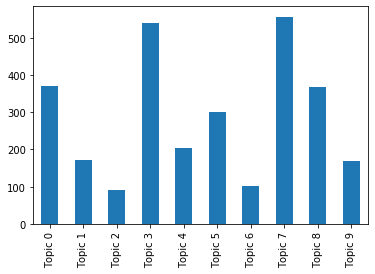

In [18]:
j['Top Topic'].value_counts().sort_index().plot(kind='bar')

In [27]:
num_words = 10
for col in j.columns[j.columns.str.match(r'Topic \d+')]:
    key_words = H.sort_values(col, ascending=False).head(num_words).index.tolist()
    print(f'{col}: {" ".join(key_words)}')

Topic 0: human evolution cultural world culture order species natural value nature
Topic 1: population years populations thousand ancestry ago dna today native africa
Topic 2: sexual female male males females choice mate evolutionary preferences aesthetic
Topic 3: state socialist society government power free social political lenin revolution
Topic 4: white man black men america class women slave muhammad mr
Topic 5: people make common rich things social skin game say like
Topic 6: change elephant behavior rider ve got situation looks surprise direction
Topic 7: person want don know way make good think believe like
Topic 8: time work things day hours deep important spend makes doing
Topic 9: life suffering meaning happiness way death ceases finds live man


In [32]:
topic = 4
title = f'Topic {topic}'
j[j['Top Topic'] == title].sort_values(title,  ascending=False).head(5)

,Highlight,Book Title,Book Author,Amazon Book ID,Note,Color,Tags,Location Type,Location,Highlighted at,...,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Top Topic
764,"There was a color pattern in the huge crowds. Once I happened to notice this, I closely observed it thereafter. Being from America made me intensely sensitive to matters of color. I saw that people who looked alike drew together and most of the time stayed together. This was entirely voluntary; there being no other reason for it. But Africans were with Africans. Pakistanis were with Pakistanis. And so on. I tucked it into my mind that when I returned home I would tell Americans this observat...",The Autobiography of Malcolm X,Malcolm X,NaN,NaN,NaN,NaN,order,1.0,2020-11-08 13:35:41.400497+00:00,...,0.0,0.0,0.0,0.348573,0.000000,0.0,0.000000,0.0,0.0,Topic 4
755,"I tell sincere white people, “Work in conjunction with us—each of us working among our own kind.” Let sincere white individuals find all other white people they can who feel as they do—and let them form their own all-white groups, to work trying to convert other white people who are thinking and acting so racist. Let sincere whites go and teach non-violence to white people!",The Autobiography of Malcolm X,Malcolm X,NaN,NaN,NaN,NaN,order,3.0,2020-11-08 13:35:42.288043+00:00,...,0.0,0.0,0.0,0.338528,0.000000,0.0,0.000000,0.0,0.0,Topic 4
785,"The reporters would try their utmost to raise some “good” white man whom I couldn’t refute as such. I’ll never forget how one practically lost his voice. He asked me did I feel any white men had ever done anything for the black man in America. I told him, “Yes, I can think of two. Hitler, and Stalin. The black man in America couldn’t get a decent factory job until Hitler put so much pressure on the white man. And then Stalin kept up the pressure—”",The Autobiography of Malcolm X,Malcolm X,NaN,NaN,NaN,NaN,order,1.0,2020-11-08 13:35:38.114638+00:00,...,0.0,0.0,0.0,0.306701,0.000000,0.0,0.000000,0.0,0.0,Topic 4
768,"“During the past eleven days here in the Muslim world, I have eaten from the same plate, drunk from the same glass, and slept in the same bed (or on the same rug)—while praying to the same God—with fellow Muslims, whose eyes were the bluest of blue, whose hair was the blondest of blond, and whose skin was the whitest of white. And in the words and in the actions and in the deeds of the ‘white’ Muslims, I felt the same sincerity that I felt among the black African Muslims of Nigeria, Sudan, a...",The Autobiography of Malcolm X,Malcolm X,NaN,NaN,NaN,NaN,order,4.0,2020-11-08 13:35:40.175433+00:00,...,0.0,0.0,0.0,0.302345,0.000000,0.0,0.010097,0.0,0.0,Topic 4
765,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.287719,0.002679,0.0,0.005283,0.0,0.0,Topic 4


In [17]:
pt = pd.pivot_table(j, index='Book Title', columns='Top Topic', values='Highlight', aggfunc='count', fill_value=0)
pt = pt[pt.sum(axis=1) >= 10]
pt = pt / pt.sum(axis=1).values.reshape(-1,1)
pt.style.background_gradient(cmap ='viridis', axis=1) \
        .set_properties(**{'font-size': '12px'})

Top Topic,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
Book Title,,,,,,,,,,
12 Rules for Life: An Antidote to Chaos,0.208333,0.083333,0.041667,0.083333,0.000000,0.125000,0.000000,0.208333,0.041667,0.208333
A Random Walk Down Wall Street: The Time-Tested Strategy for Successful Investing (Eleventh Edition),0.027778,0.027778,0.000000,0.250000,0.055556,0.055556,0.027778,0.055556,0.472222,0.027778
Against the Grain: A Deep History of the Earliest States,0.076923,0.000000,0.000000,0.269231,0.000000,0.038462,0.000000,0.461538,0.115385,0.038462
Are We Smart Enough to Know How Smart Animals Are?,0.343750,0.000000,0.000000,0.000000,0.250000,0.031250,0.093750,0.187500,0.031250,0.062500
Darwin's Dangerous Idea: Evolution and the Meaning of Life,0.300000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.200000,0.300000
"Debt - Updated and Expanded: The First 5,000 Years",0.074074,0.037037,0.000000,0.259259,0.185185,0.000000,0.074074,0.259259,0.074074,0.037037
Deep Work: Rules for Focused Success in a Distracted World,0.166667,0.023810,0.000000,0.142857,0.000000,0.119048,0.000000,0.380952,0.142857,0.023810
Drive: The Surprising Truth About What Motivates Us,0.029412,0.000000,0.000000,0.000000,0.000000,0.264706,0.117647,0.264706,0.323529,0.000000
Economic Sophisms,0.000000,0.000000,0.285714,0.428571,0.000000,0.142857,0.000000,0.000000,0.000000,0.142857
